In [1]:
from metrics import *
import torch
from torch_geometric.datasets import Amazon
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from time import time
from tqdm import tqdm
from utils import *
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap
import trimap
from umap import UMAP
import warnings

random_state = 0
random.seed(0)
torch.manual_seed(0)

warnings.filterwarnings('ignore', message="n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.")
warnings.filterwarnings('ignore', message="Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.")
warnings.filterwarnings('ignore', message="Graph is not fully connected, spectral embedding may not work as expected.")

print("Cuda available?", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda available? True


In [2]:
dataset_name = "Amazon"
original_gnn = "GNN"
algorithm_name = "UMAP"


dataset = Amazon(root='.', name='Computers')
data = dataset[0].to(device)
generate_train_test(data)


X = dataset[0].x.cpu().detach().numpy()
y = dataset[0].y.cpu().numpy()


In [3]:
model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loop(200, model, optimizer, data)

# Extract features with the trained GNN
model.eval()
with torch.no_grad():
    gnn_output = model(data)

# Move the features to CPU for t-SNE
gnn_output = gnn_output.cpu().numpy()

Calculating d_hd
Amazon UMAP-euclidean
Calculating d_hd
Amazon UMAP-manhattan
Calculating d_hd
Amazon UMAP-cosine
Finished.


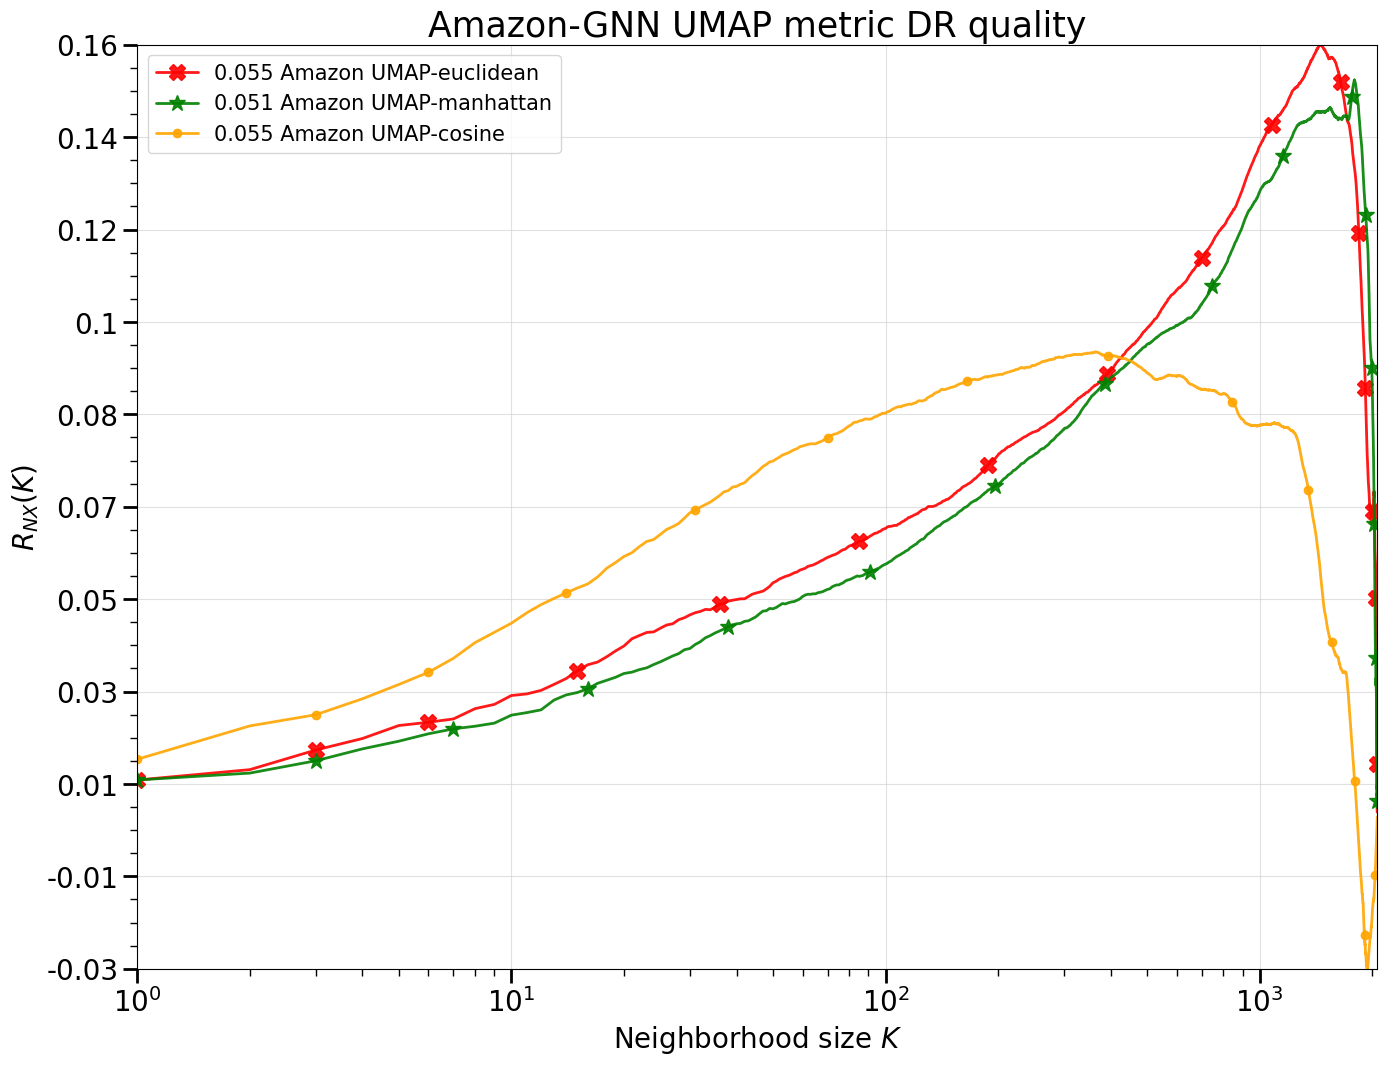

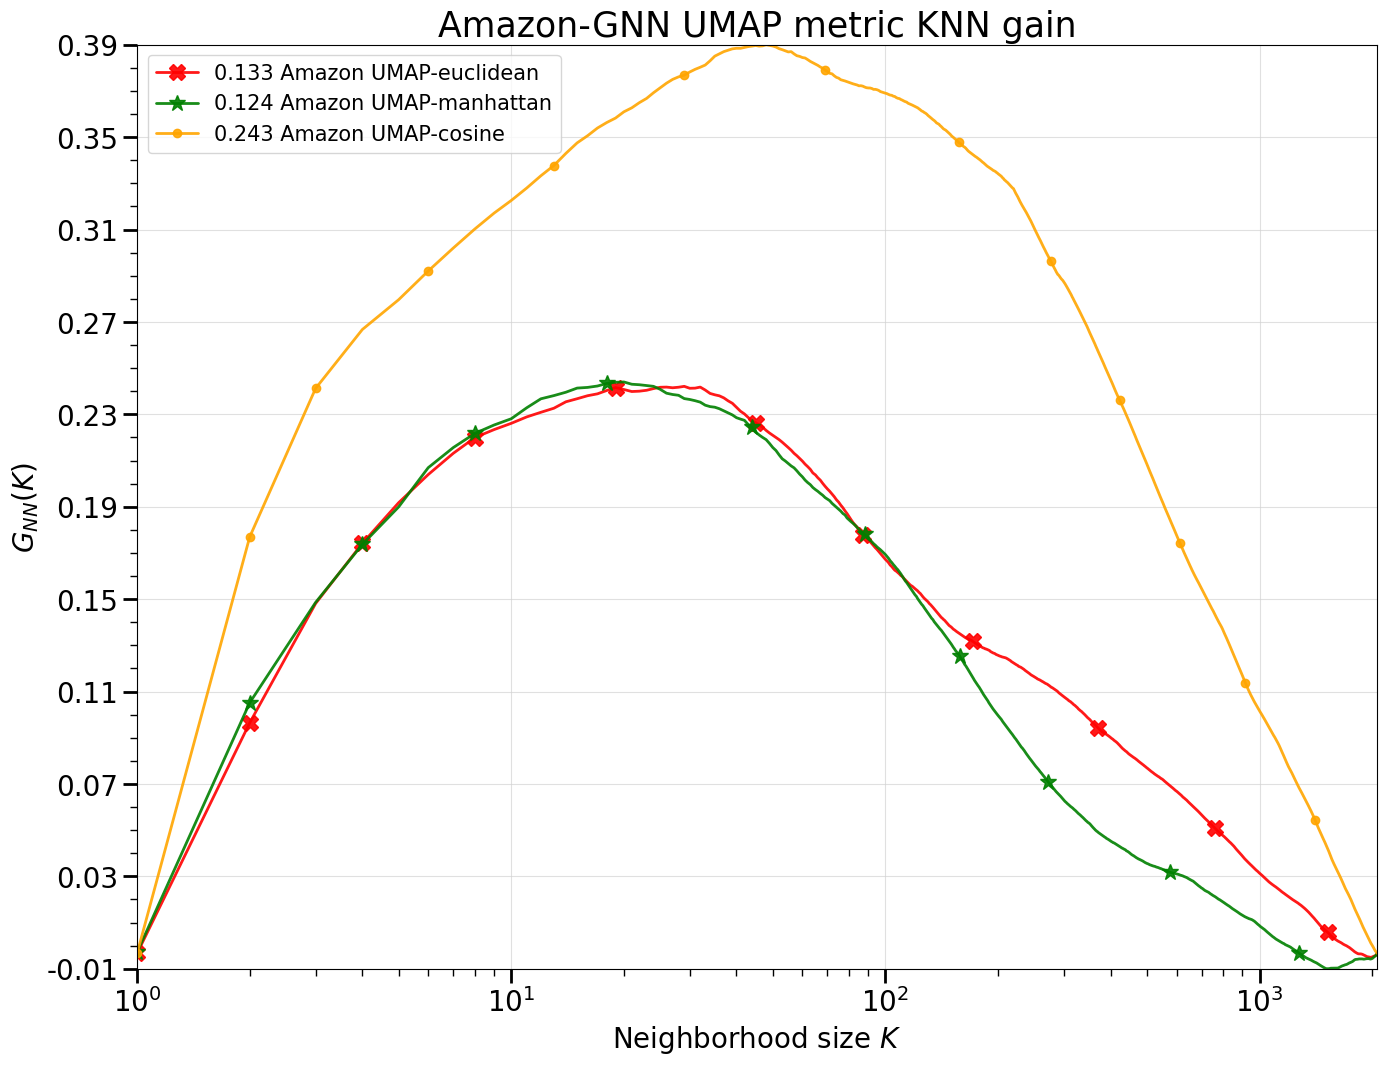

In [4]:
local_metrics = LocalMetric()

for metric in ['euclidean', 'manhattan', 'cosine']:
    umap_post = UMAP(n_components=2, random_state=0, metric=metric)
    umap_results = umap_post.fit_transform(gnn_output)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=umap_results,
        X_hds=X,
        labels=y,
        method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{metric}"),
    )

local_metrics.visualize(f"{dataset_name}-{original_gnn} {algorithm_name} metric")

Calculating d_hd
Amazon UMAP-0.1
Calculating d_hd
Amazon UMAP-0.25
Calculating d_hd
Amazon UMAP-0.5
Calculating d_hd
Amazon UMAP-0.99
Finished.


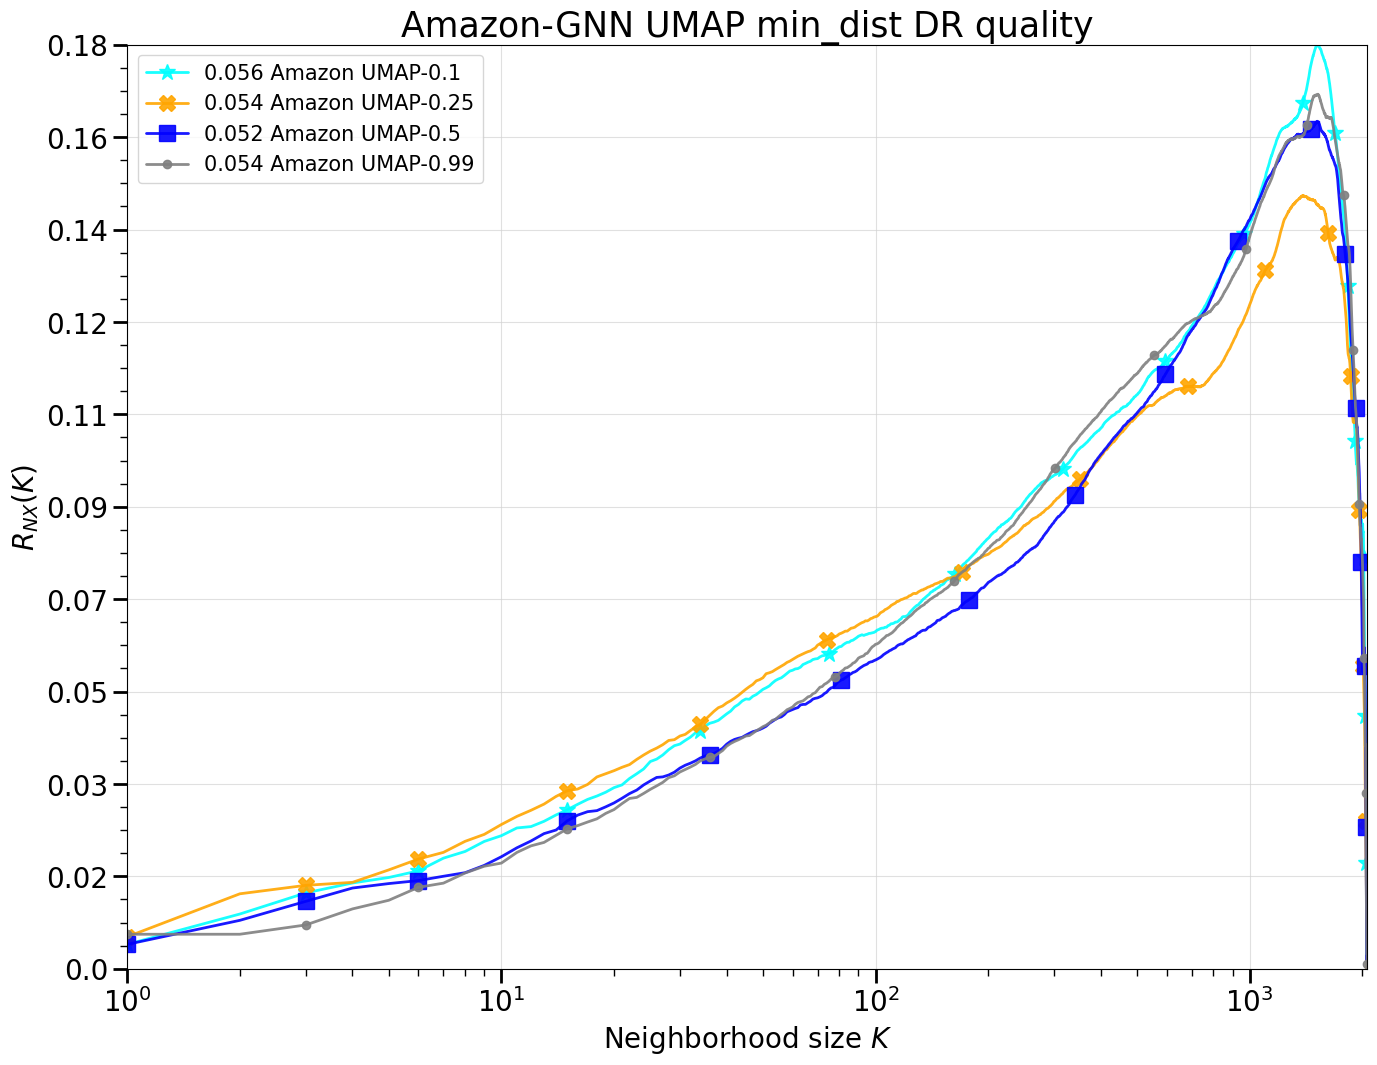

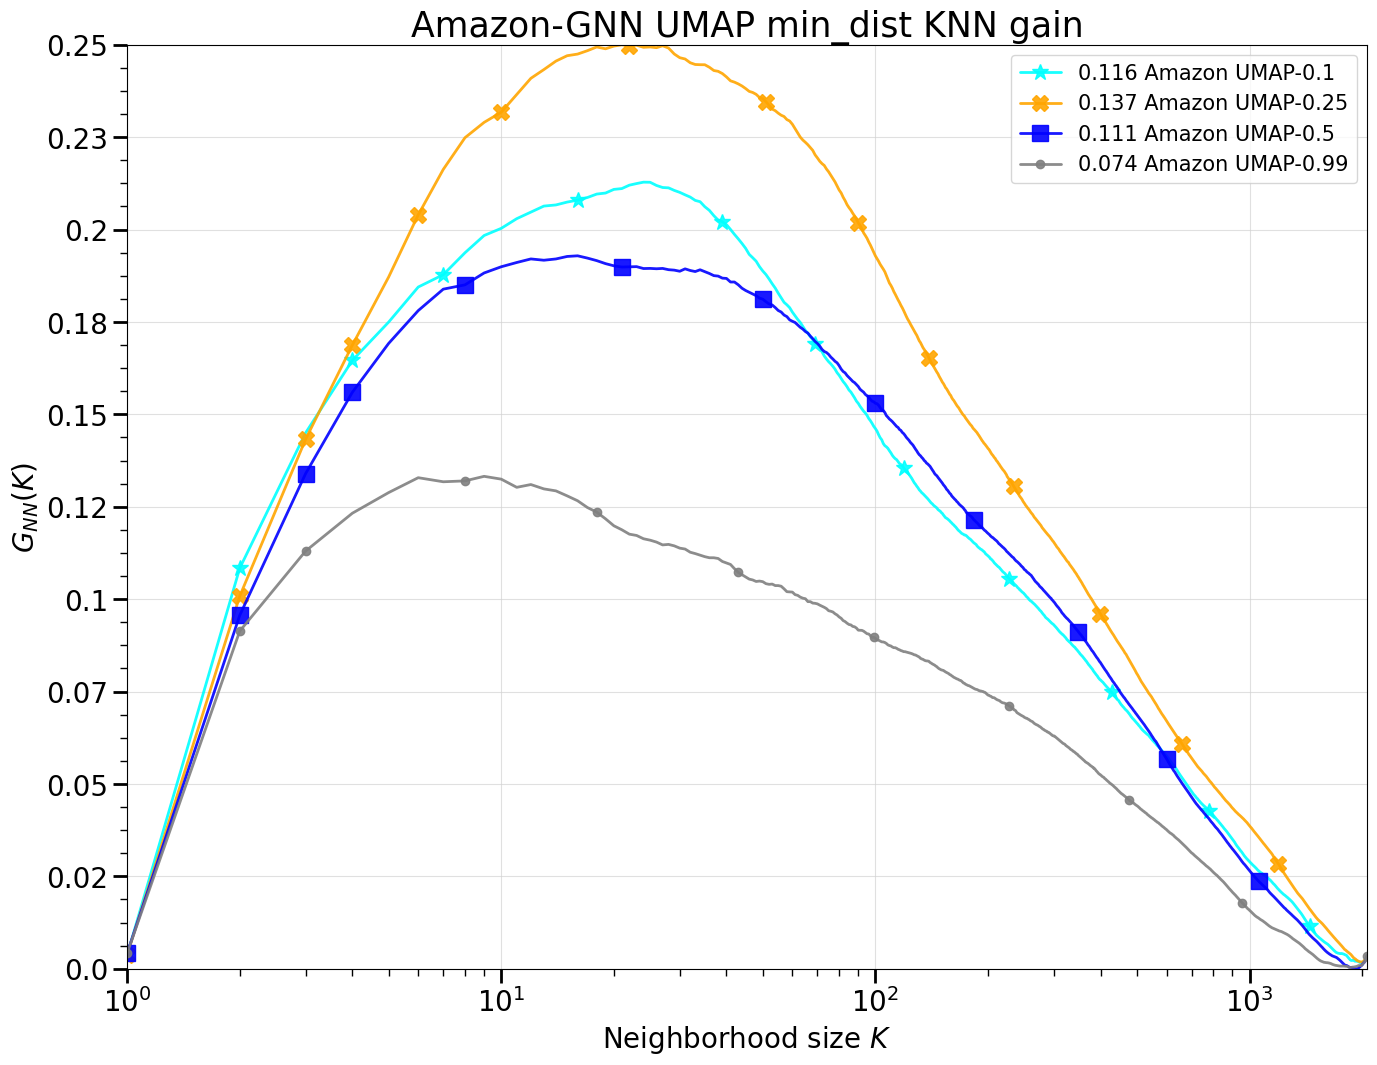

In [5]:
local_metrics = LocalMetric()

for min_dist in [0.1, 0.25, 0.5, 0.99]:
    
    umap_post = UMAP(n_components=2, random_state=0, min_dist=min_dist)
    umap_results = umap_post.fit_transform(gnn_output)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=umap_results,
        X_hds=X,
        labels=y,
        method_name="{} {}".format(dataset_name, f"{algorithm_name}-{min_dist}"),
    )

local_metrics.visualize(f"{dataset_name}-{original_gnn} {algorithm_name} min_dist")

Calculating d_hd
Amazon UMAP-10
Calculating d_hd
Amazon UMAP-20
Calculating d_hd
Amazon UMAP-30
Finished.


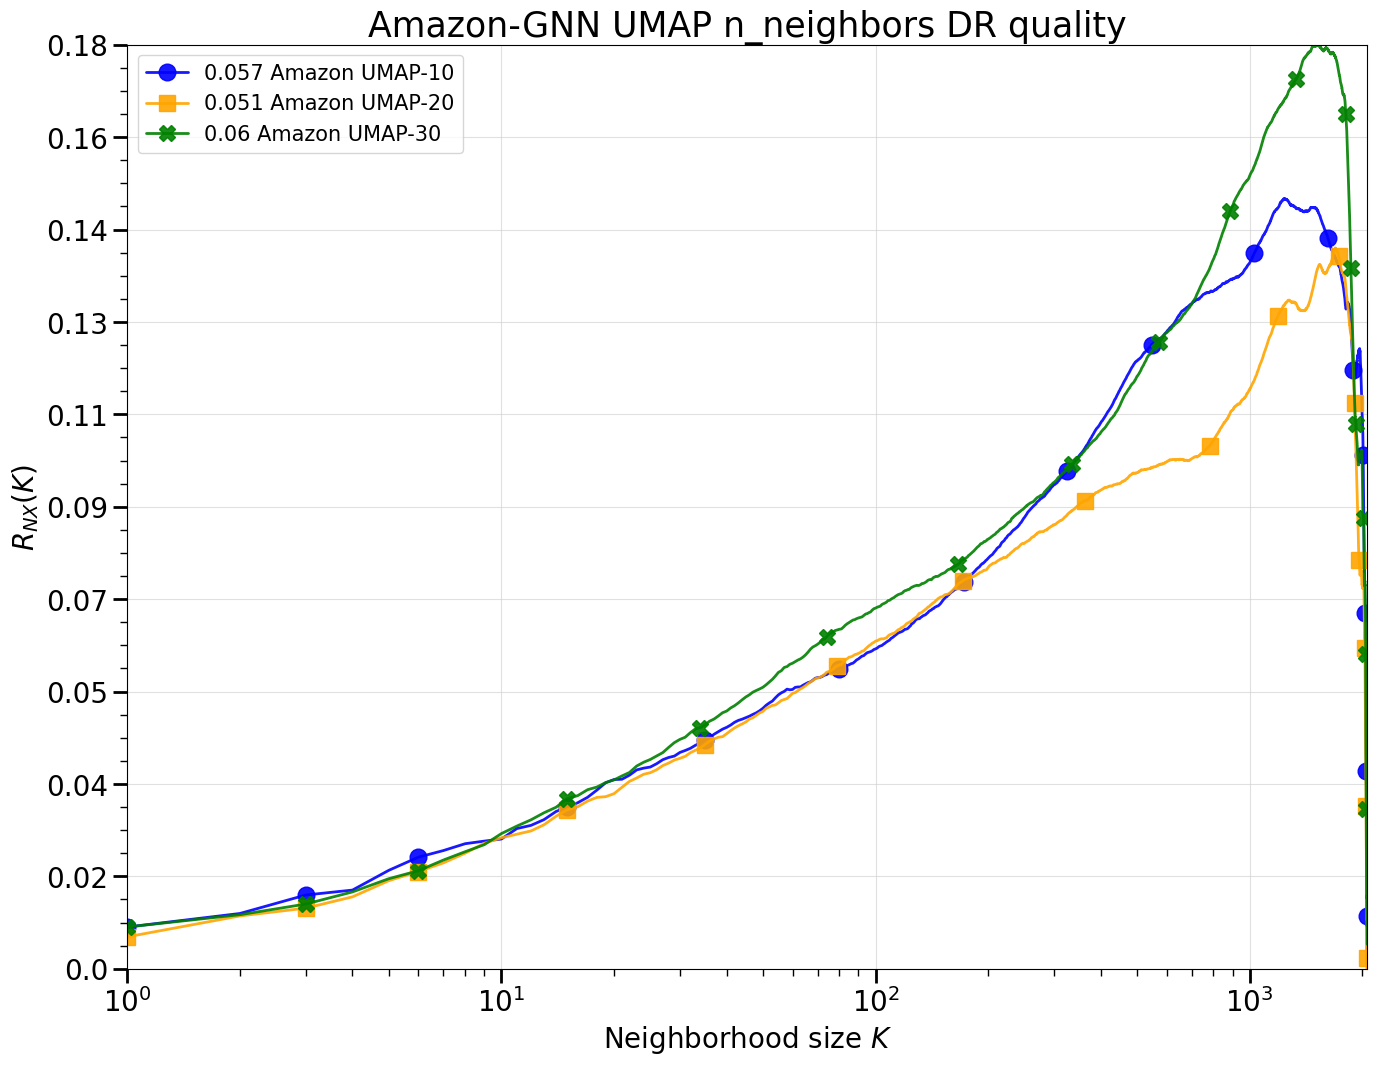

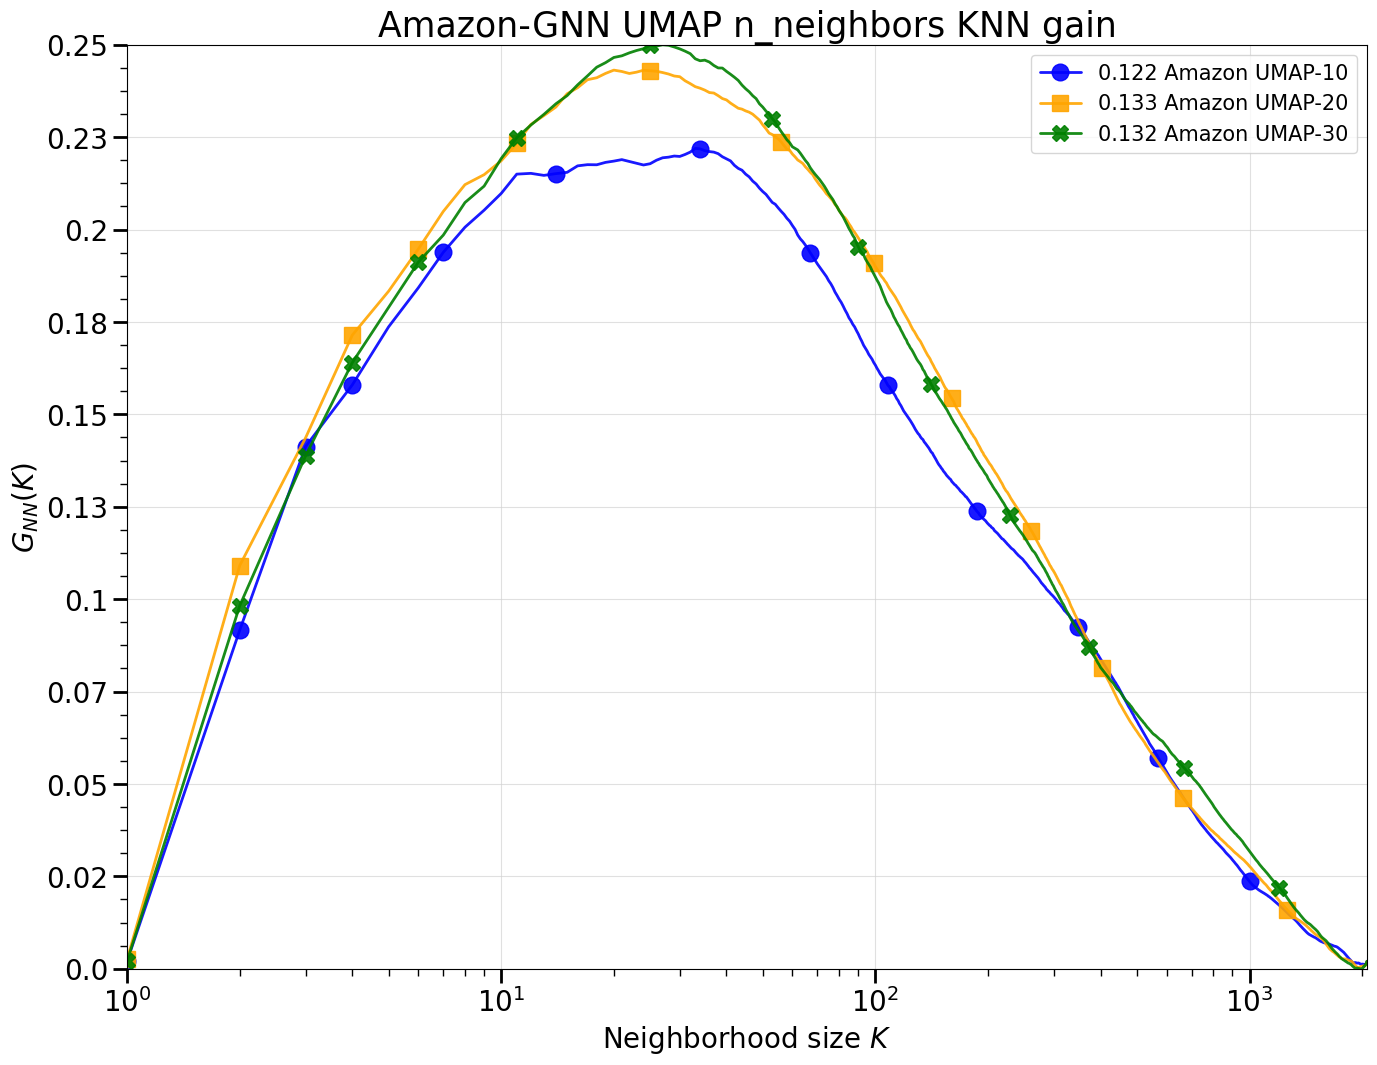

In [6]:
local_metrics = LocalMetric()

for n_neighbors in [10, 20, 30]:

    umap_post = UMAP(n_components=2, random_state=0, n_neighbors=n_neighbors)
    umap_results = umap_post.fit_transform(gnn_output)


    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=umap_results,
        X_hds=X,
        labels=y,
        method_name="{} {}".format(dataset_name, f"{algorithm_name}-{n_neighbors}"),
    )

local_metrics.visualize(f"{dataset_name}-{original_gnn} {algorithm_name} n_neighbors")